In [27]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense 

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Computer.House\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1. Load the dataset

In [3]:
df = pd.read_csv('/Amit course/final project/train.csv')

2. Check head and info of the data

In [4]:
df.head(100)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will hel...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an ac...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


3. Is there a missing data and how many and the percentage if there?

In [7]:
null_data = df.isnull()

missing_data = {
    "count": null_data.sum(),
    "Percentage": null_data.mean() * 100    # Mean is the summation over the length,
    # "Percentage": (null_data.sum() / len(df)) * 100
}

pd.DataFrame(data=missing_data)

,count,Percentage
id,0,0.000000
keyword,61,0.801261
location,2533,33.272035
text,0,0.000000
target,0,0.000000


4. How many data in each class?

In [6]:
df.target.value_counts()


0    4342
1    3271
Name: target, dtype: int64

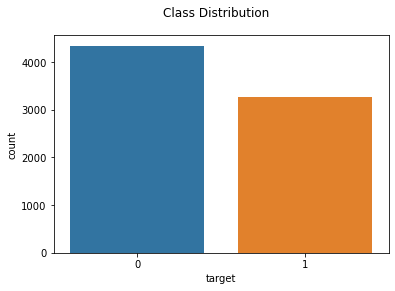

In [8]:
sns.countplot(x='target', data=df)

plt.suptitle('Class Distribution')
plt.show()

5. Get the top 15 locations of the data

In [8]:
df.groupby('location').agg({'id': 'count'}).reset_index().sort_values('id',ascending=False).iloc[0:15]


,location,id
2643,USA,104
1826,New York,71
2662,United States,50
1506,London,45
587,Canada,29
1860,Nigeria,28
2632,UK,27
1534,"Los Angeles, CA",26
1262,India,24
1719,Mumbai,22


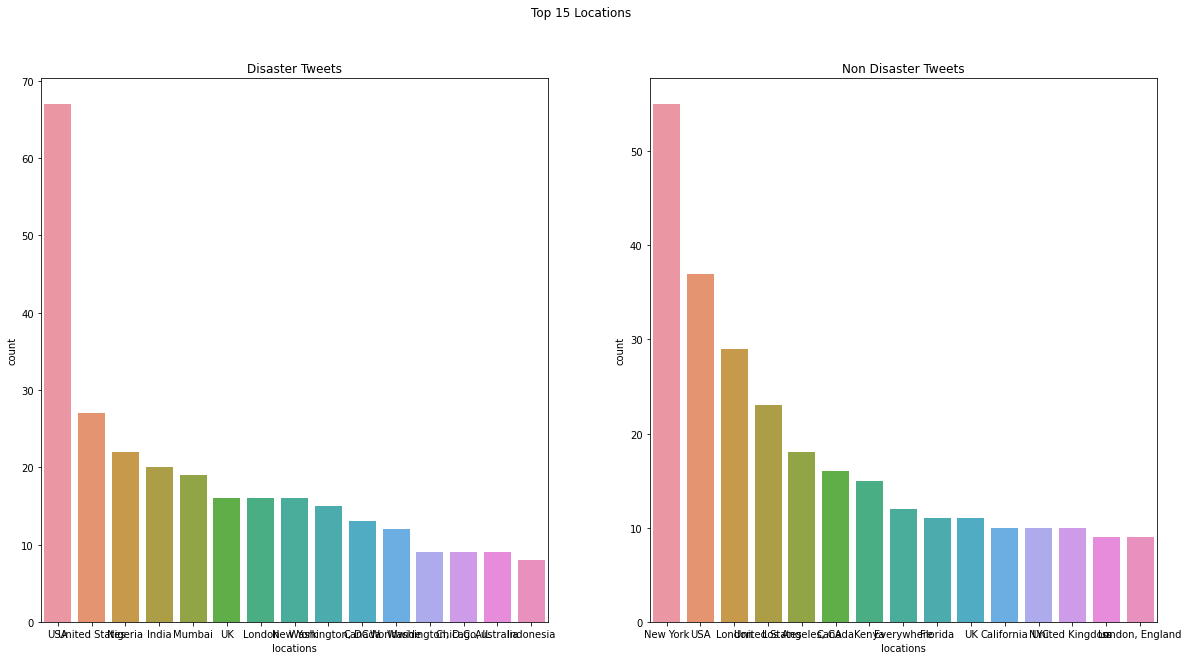

In [9]:
disaster_count = df[df['target']==1]['location'].value_counts()[:15]
none_disaster_count = df[df['target']==0]['location'].value_counts()[:15]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

sns.barplot(y=disaster_count.values, x=disaster_count.index, ax=ax[0])
ax[0].set(ylabel='count', xlabel='locations', title='Disaster Tweets')

sns.barplot(y=none_disaster_count.values, x=none_disaster_count.index, ax=ax[1])
ax[1].set(ylabel='count', xlabel='locations', title='Non Disaster Tweets')

plt.suptitle('Top 15 Locations')
plt.show()

In [10]:
df.groupby('keyword').agg({'id': 'count'}).reset_index().sort_values('id',ascending=False).iloc[0:15]


,keyword,id
104,fatalities,45
63,deluge,42
8,armageddon,42
177,sinking,41
57,damage,41
119,harm,41
29,body%20bags,41
153,outbreak,40
95,evacuate,40
106,fear,40


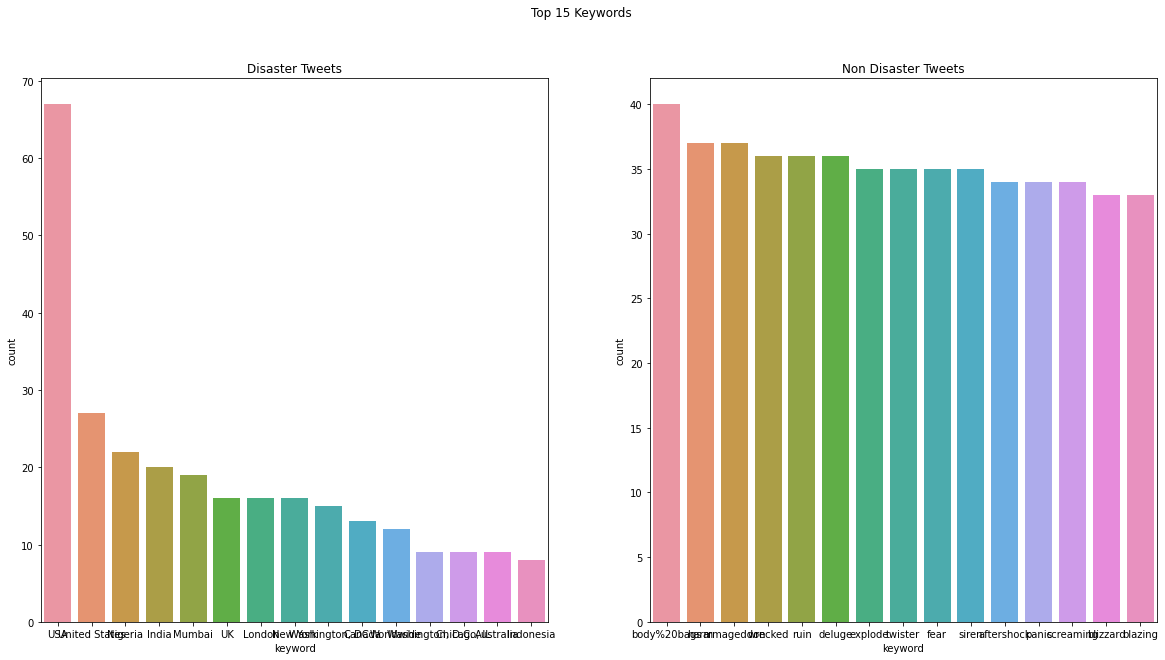

In [10]:
isaster_count = df[df['target']==1]['keyword'].value_counts()[:15]
none_disaster_count = df[df['target']==0]['keyword'].value_counts()[:15]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

sns.barplot(y=disaster_count.values, x=disaster_count.index, ax=ax[0])
ax[0].set(ylabel='count', xlabel="keyword", title='Disaster Tweets')

sns.barplot(y=none_disaster_count.values, x=none_disaster_count.index, ax=ax[1])
ax[1].set(ylabel='count', xlabel='keyword', title='Non Disaster Tweets')

plt.suptitle('Top 15 Keywords')
plt.show()

7. What are the most common words?

In [12]:
def build_corpus(target_column_name, text_column_name, val):
    corpus = []
    for text in df[df[target_column_name]==val][text_column_name].str.split():
        for subtext in text:
            corpus.append(subtext)
    return corpus

corpus_disaster = build_corpus("target", "text", 1)
corpus_nondisaster = build_corpus("target", "text", 0)

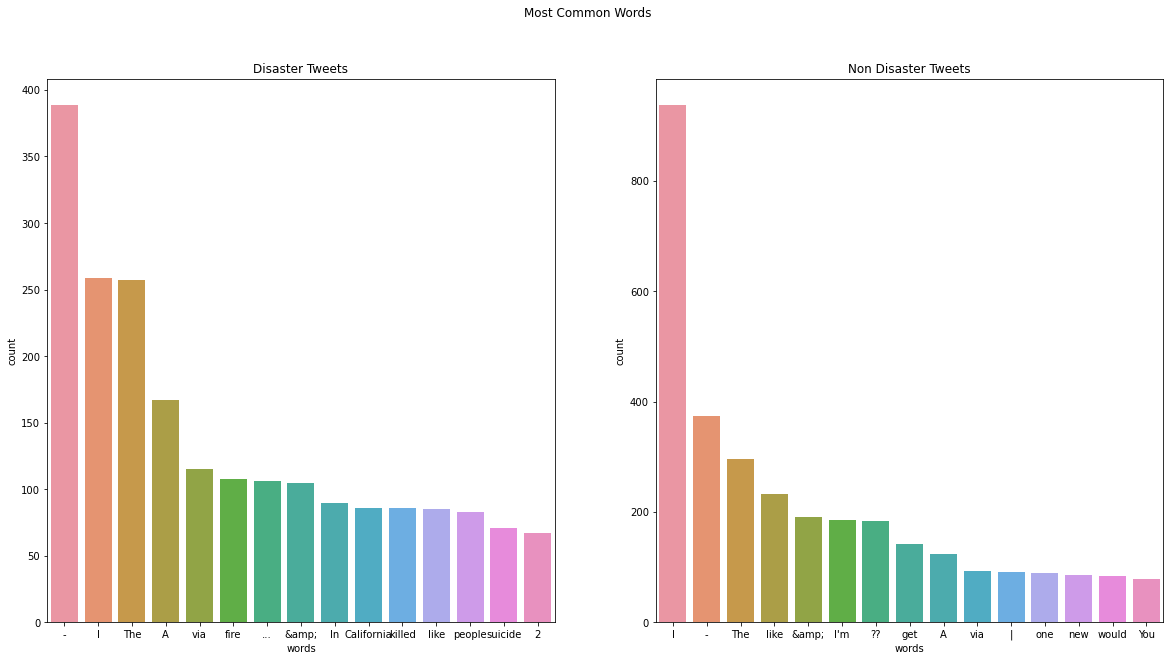

In [13]:
stop_words = stopwords.words('english')

def get_most_common_words(corpus, stop_word):
    common_words = []
    for word in corpus:
        if word not in stop_word:
            common_words.append(word)
    return common_words

common_words_disaster = get_most_common_words(corpus_disaster, stop_words)
common_words_nondisaster = get_most_common_words(corpus_nondisaster, stop_words)
        
counter_disaster = Counter(common_words_disaster)
counter_nondisaster = Counter(common_words_nondisaster)

word_disaster, word_count_disaster = map(list, zip(*counter_disaster.most_common()[:15]))
word_nondisaster, word_count_nondisaster = map(list, zip(*counter_nondisaster.most_common()[:15]))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

sns.barplot(y=word_count_disaster, x=word_disaster, ax=ax[0])
ax[0].set(ylabel='count', xlabel='words', title='Disaster Tweets')

sns.barplot(y=word_count_nondisaster, x=word_nondisaster, ax=ax[1])
ax[1].set(ylabel='count', xlabel='words', title='Non Disaster Tweets')

fig.suptitle('Most Common Words')
plt.show()

In [11]:
x_train = pd.read_csv('/Amit course/final project/train.csv', usecols=["id", "text", "target"])
x_test = pd.read_csv('/Amit course/final project/test.csv', usecols=["id", "text"])

y_train = x_train['target'].values

In [12]:
text_train = x_train.text.values
text_test = x_test.text.values
print(text_train[:10])

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 "I'm on top of the hill and I can see a fire in the woods..."
 "There's an emergency evacuation happening now in the building across the street"
 "I'm afraid that the tornado is coming to our area..."]


In [30]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

In [31]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train)
X_test = keras.preprocessing.sequence.pad_sequences(X_test)

print(X_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0  119 4633   24    4  868    8   21  263
  138 1619 4634   89   40]


In [32]:
vocab_size = len(tokenizer.word_index)
print('Vocabulary Size:', vocab_size)

Vocabulary Size: 22700


In [37]:
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [38]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1, output_dim = 128))
model.add(LSTM(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='relu'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2905728   
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,341,185
Trainable params: 3,341,185
Non-trainable params: 0
_________________________________________________________________


In [39]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True, epochs=25, batch_size=1024, callbacks=[early_stopping])

Epoch 1/25
6/6 [==============================] - 10s 1s/step - loss: 1.8820 - accuracy: 0.5695 - val_loss: 0.9414 - val_accuracy: 0.5739
Epoch 2/25
6/6 [==============================] - 9s 1s/step - loss: 0.8111 - accuracy: 0.5695 - val_loss: 0.6741 - val_accuracy: 0.5739
Epoch 3/25
6/6 [==============================] - 9s 1s/step - loss: 0.6658 - accuracy: 0.5401 - val_loss: 0.6880 - val_accuracy: 0.4846
Epoch 4/25
6/6 [==============================] - 8s 1s/step - loss: 0.6110 - accuracy: 0.7381 - val_loss: 0.6271 - val_accuracy: 0.6815
Epoch 5/25
6/6 [==============================] - 9s 1s/step - loss: 0.5682 - accuracy: 0.7816 - val_loss: 0.6078 - val_accuracy: 0.7124
Epoch 6/25
6/6 [==============================] - 9s 2s/step - loss: 0.5152 - accuracy: 0.8550 - val_loss: 0.5772 - val_accuracy: 0.7196
Epoch 7/25
6/6 [==============================] - 10s 2s/step - loss: 0.4424 - accuracy: 0.8479 - val_loss: 0.5582 - val_accuracy: 0.7019
Epoch 8/25
6/6 [=======================

12. Evaluate the model and make predictions

In [40]:
train_score = model.evaluate(x_val, y_val)

48/48 [==============================] - 1s 24ms/step - loss: 1.7092 - accuracy: 0.7669


In [41]:
preds = model.predict(X_test).flatten()
preds

array([0.33791226, 0.2317696 , 1.1570895 , ..., 0.7726482 , 0.6266731 ,
       1.0803487 ], dtype=float32)

13. Evaluate the results with charts of acc and loss

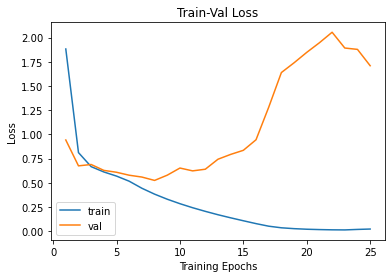

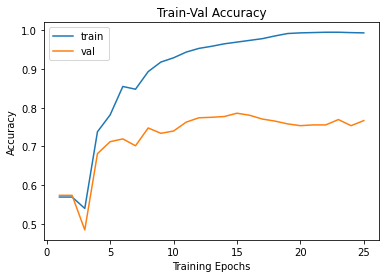

In [42]:
def plot_history(loss_hist, metric_hist):
    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1), loss_hist["train"], label="train")
    plt.plot(range(1,num_epochs+1), loss_hist["val"], label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

loss_hist = {
    "train": history.history['loss'],
    "val": history.history['val_loss'],
}

metric_hist = {
    "train": history.history["accuracy"],
    "val": history.history["val_accuracy"]
}

plot_history(loss_hist, metric_hist)

14. Save your model

In [45]:
model.save("Amit course/final project/GP.ipynb")

INFO:tensorflow:Assets written to: Amit course/final project/GP.ipynb\assets
